In [157]:
import pandas as pd
import numpy as np
import seaborn as sns

In [158]:
import matplotlib.pyplot as plt

%matplotlib inline

In [159]:
from datetime import date

In [160]:
import scipy.stats
import pingouin as pg

# 1 задание

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

Данные о времени регистрации:

In [161]:
reg_data=pd.read_csv('problem1-reg_data.csv',sep=";")

Данные о времени захода пользователей в игру:

In [162]:
auth_data=pd.read_csv('problem1-auth_data.csv',sep=";")

### Проведём первичный анализ данных о времени регестрации:

In [163]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [164]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [165]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [166]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

Пропущенных значений нет

In [167]:
reg_data.shape

(1000000, 2)

In [168]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

Все id в данных уникальны

In [169]:
reg_data.duplicated().sum()

0

Дубликатов нет

Посмотрим за какой временной интервал нам доступны данные

In [170]:
pd.to_datetime(reg_data['reg_ts'], unit='s').min()

Timestamp('1998-11-18 09:43:43')

In [171]:
pd.to_datetime(reg_data['reg_ts'], unit='s').max()

Timestamp('2020-09-23 15:17:24')

### Проведем первичный анализ данных о времени захода пользователей в игру:

In [172]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [173]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [174]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [175]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Пропущенных значений нет

In [176]:
auth_data.duplicated().sum()

0

Дубликатов нет

Посмотрим за какой временной интервал нам доступны данные

In [177]:
pd.to_datetime(auth_data['auth_ts'], unit='s').min()

Timestamp('1998-11-18 09:43:43')

In [178]:
pd.to_datetime(auth_data['auth_ts'], unit='s').max()

Timestamp('2020-09-23 15:17:24')

#### Вывод по первичному анализу данных:

Дубликатов и пропущенных значений нет, данные готовы к работе. Временной интервал, за который собрана информация достаточно большой - около 22-х лет. В этом задании напишем функцию для вычисления показателя n-day retention и когортного анализа для последнего года (12 месяцев от последней даты), т.к. динамика использования приложения могла сильно измениться за такой длинный период времени и было бы нецелесообразно считать n-day retention и проводить когортный анализ за весь период.

### Функция retention


In [179]:
def retention(reg_data,auth_data):
    '''Функция retention принимает на вход 2 аргумента: данные о регистрации пользователей reg_data и данные о заходе в игру 
    auth_data и возвращает таблицу n_day_retention, показывающую сколько процентов пользователей, начавших пользоваться продуктом 
    в день 0, вернулись и продолжили использовать продукт N дней спустя и таблицу retention_by_cohorts с помесячным показателем 
    retention для разных когорт пользователей (когорта-пользователи, зарегистрировашиеся в приложении в один месяц).
    Используются данные за последние 12 месяцев.'''
    #Переведем колонку reg_ts из формата timestamp в datetime
    reg_data['reg_date']=pd.to_datetime(reg_data['reg_ts'], unit='s')
    #Оставим только дату
    reg_data['reg_date'] = reg_data['reg_date'].dt.date
    #Переведем колонку auth_ts из формата timestamp в datetime
    auth_data['auth_date']=pd.to_datetime(auth_data['auth_ts'], unit='s')
    #Оставим только дату
    auth_data['auth_date'] = auth_data['auth_date'].dt.date
    
    #Расчитаем n-day retention
    
    max_date=auth_data.auth_date.max()
    start=(max_date-pd.Timedelta(365,unit='d'))
    #отберём данные за последний год
    reg_data_last_year=reg_data[reg_data.reg_date>=start]
    auth_data_last_year=auth_data[auth_data.auth_date>=start]
    #объединение датафреймов
    data_last_year=reg_data_last_year.join(auth_data_last_year.set_index('uid'),how='left',on='uid')
    data_last_year=data_last_year[data_last_year.auth_date>=data_last_year.reg_date]
    data_last_year=data_last_year[['uid','reg_date','auth_date']]
    data_last_year=data_last_year[data_last_year.auth_date>=data_last_year.reg_date]
    #Создаём колонку diff, содержащую информацию о том, сколько времени прошло между регистрацией и очередным заходом в игру
    data_last_year['diff'] = data_last_year['auth_date'] - data_last_year['reg_date']
    data_last_year['diff'] = data_last_year['diff'].dt.days
    n_day_retention = data_last_year.groupby('diff').agg({'uid': 'nunique'})
    n_day_retention=n_day_retention.rename(columns={'uid':'users'})
    n_day_retention['retention_rate'] = n_day_retention['users'] / n_day_retention.users.max()
    
    #Когортный анализ
    
    reg_data['reg_date']=reg_data['reg_date'].astype('datetime64[M]')
    auth_data['auth_date']=auth_data['auth_date'].astype('datetime64[M]')
    
    start=pd.offsets.MonthBegin().rollback(max_date-pd.Timedelta(365,unit='d'))
    auth_data_last_year_cohorts=auth_data[auth_data.auth_date>=start]
    reg_data_last_year_cohorts=reg_data[reg_data.reg_date>=start]
    data_last_year_cohorts=reg_data_last_year_cohorts.join(auth_data_last_year_cohorts.set_index('uid'),how='left',on='uid')
    data_last_year_cohorts=data_last_year_cohorts[data_last_year_cohorts.auth_date>=data_last_year_cohorts.reg_date]
    data_last_year_cohorts['lifetime'] = ((data_last_year_cohorts['auth_date'] - data_last_year_cohorts['reg_date'])/np.timedelta64(1, 'M')).\
    round().astype(int)
    data_last_year_cohorts=data_last_year_cohorts.rename(columns={'reg_date':'cohort'})
    data_last_year_cohorts=data_last_year_cohorts.groupby(['cohort','lifetime'])['uid'].nunique().to_frame()
    data_last_year_cohorts['retention_rate'] = data_last_year_cohorts['uid'] / data_last_year_cohorts.groupby(["cohort"])["uid"].transform("max")
    retention_by_cohorts=pd.pivot_table(data=data_last_year_cohorts,index='cohort',columns='lifetime',values='retention_rate')
    
    
    return n_day_retention, retention_by_cohorts

In [180]:
n_day_retention, retention_by_cohorts=retention(reg_data,auth_data)

In [183]:
n_day_retention[:10]

,users,retention_rate
diff,,
0,451869,1.000000
1,9070,0.020072
2,18474,0.040884
3,20599,0.045586
4,23544,0.052104
5,26693,0.059072
6,30544,0.067595
7,25668,0.056804
8,21027,0.046533


In [182]:
retention_by_cohorts

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2019-09-01,1.0,0.174042,0.062835,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107
2019-10-01,1.0,0.174012,0.064901,0.050866,0.050866,0.050866,0.050866,0.050866,0.050866,0.050866,0.050866,0.050866,NaN
2019-11-01,1.0,0.175631,0.059176,0.048568,0.048568,0.048568,0.048568,0.048568,0.048568,0.048568,0.048568,NaN,NaN
2019-12-01,1.0,0.175812,0.062358,0.051159,0.051159,0.051159,0.051159,0.051159,0.051159,0.051159,NaN,NaN,NaN
2020-01-01,1.0,0.170071,0.064210,0.050070,0.050070,0.050070,0.050070,0.050070,0.050070,NaN,NaN,NaN,NaN
2020-02-01,1.0,0.176912,0.060630,0.049167,0.049167,0.049167,0.049167,0.049167,NaN,NaN,NaN,NaN,NaN
2020-03-01,1.0,0.173995,0.062797,0.051221,0.051221,0.051221,0.051221,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,1.0,0.179179,0.062111,0.051130,0.051130,0.051130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,1.0,0.175539,0.064627,0.051289,0.051289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Также добавим вспомогательную функцию для визуализации результатов выполнения функции retention

In [75]:
def retention_visualization(n_day_retention,retention_by_cohorts):
    '''Принимает на вход таблицы n_day_retention и retention_by_cohorts, полученные в результате выполнения функции retention
    и отображает соответствующие визуализации'''
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(data=retention_by_cohorts, annot=True, vmin=0.02,vmax=0.2 )
    ax.set_title('retention_by_cohorts')
    plt.show()
    plt.figure(figsize=(15,10))
    ax = sns.lineplot(data=n_day_retention, x="diff", y='retention_rate')
    ax.set_title('n_day_retention')
    plt.show()

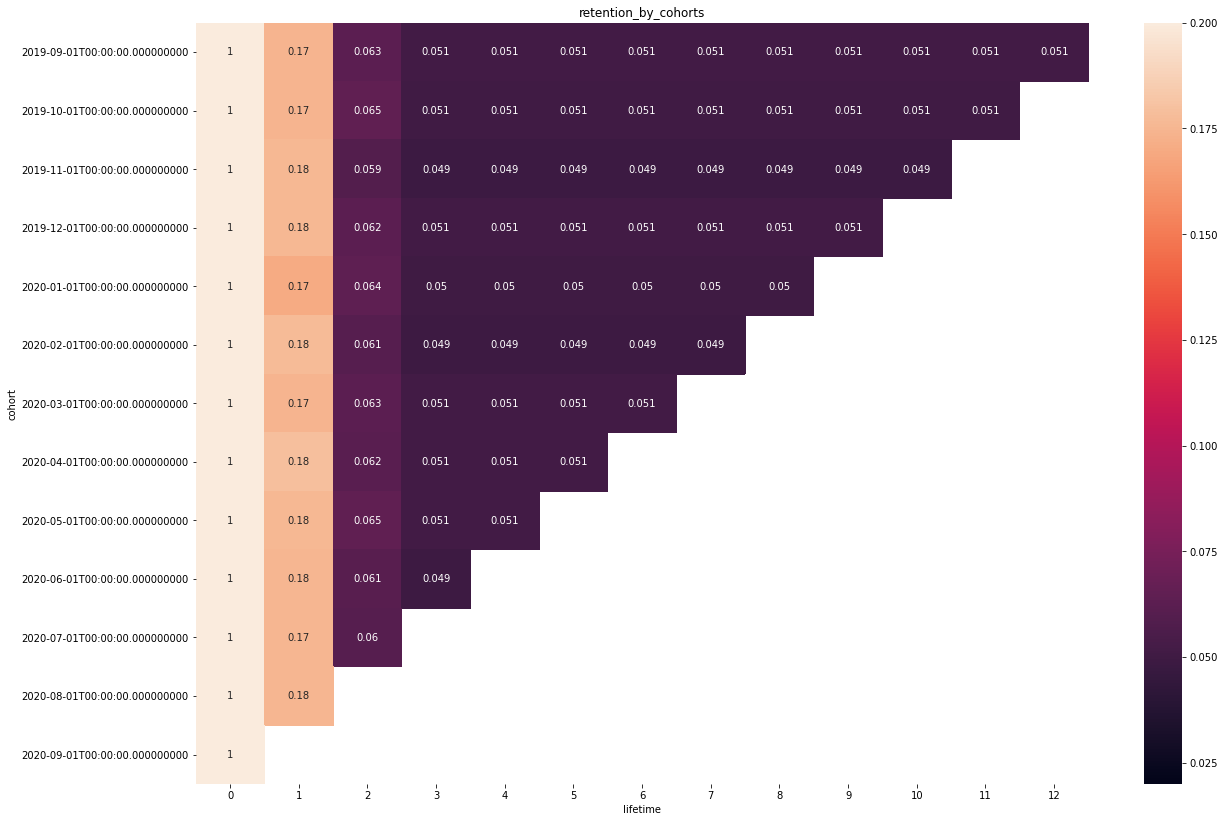

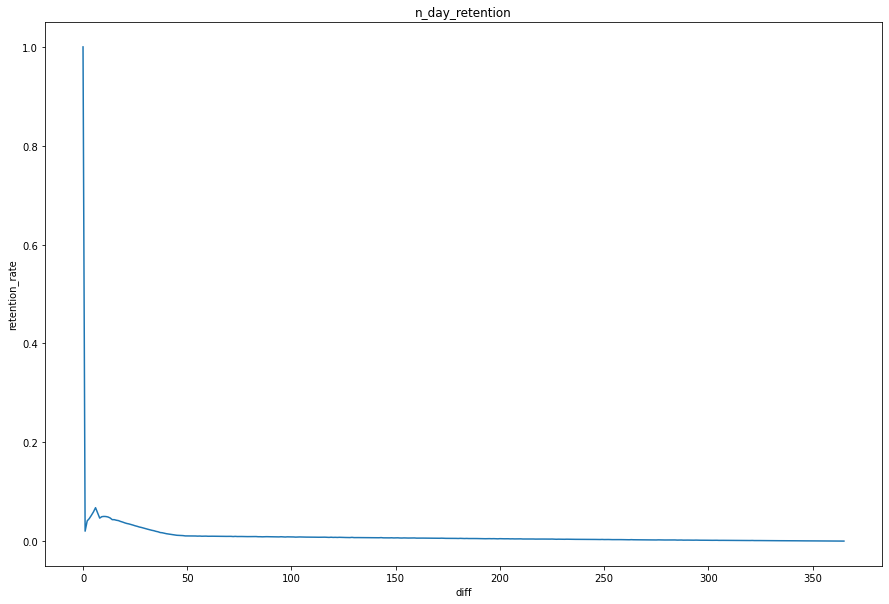

In [76]:
retention_visualization(n_day_retention,retention_by_cohorts)

# Задание 2


Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [29]:
df=pd.read_csv('Проект_1_Задание_2.csv',sep=';')

In [30]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Проведём первичный анализ данных:

In [31]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Пропущенных значений нет.

In [32]:
df.duplicated().sum()

0

Дубликатов нет.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [34]:
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


Посмотрим, сколько наблюдений в каждой группе

In [35]:
df.groupby("testgroup").size()

testgroup
a    202103
b    202667
dtype: int64

Отметим, что каждому пользователю соответствует ровно одна запись 

In [36]:
df.groupby('user_id').count().value_counts()

revenue  testgroup
1        1            404770
dtype: int64

Сколько уникальных пользователей в каждой группе?

In [37]:
df.groupby("testgroup").user_id.nunique()

testgroup
a    202103
b    202667
Name: user_id, dtype: int64

##### Оценим соотношение платящих пользователей 

In [38]:
df['is_paying']=df.revenue>0

In [39]:
df['is_paying']=df['is_paying'].apply(lambda x: 1 if x else 0)

is_paying - категориальная переменная.
Для анализа категориальных переменных будем использовать тест Хи-квадрат, с помощью которого оценим конверсию пользователей в платящих пользователей (конверсия определяется как соотношение платящих пользователей группы к всем пользователям группы).

Сначала посмотрим на таблицу сопряженности:

In [40]:
contingency_table=pd.crosstab(df.testgroup, df.is_paying)

In [41]:
contingency_table

is_paying,0,1
testgroup,,
a,200175,1928
b,200862,1805


Нулевая гипотеза: конверсия в двух группах одинакова.

In [42]:
exp, obs, stats = pg.chi2_independence(data=df, 
                                       x='testgroup', 
                                       y='is_paying') #тест с помощью библиотеки pingouin

In [43]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4.374730,1.0,0.036476,0.003288,0.552384
1,cressie-read,0.666667,4.374870,1.0,0.036473,0.003288,0.552397
2,log-likelihood,0.000000,4.375431,1.0,0.036461,0.003288,0.552450
3,freeman-tukey,-0.500000,4.376097,1.0,0.036446,0.003288,0.552513
4,mod-log-likelihood,-1.000000,4.376973,1.0,0.036428,0.003288,0.552596
5,neyman,-2.000000,4.379356,1.0,0.036377,0.003289,0.552821


In [44]:
chi2, p_value, dof, ex = scipy.stats.chi2_contingency(contingency_table) #тест с помощью библиотеки scipy.stats

In [45]:
p_value

0.03647561892312613

Так как p-value < 0.05, у нас есть основания отклонить нулевую гипотезу.
Следовательно, конверсия пользователей в платящих пользователей различается.

Посмотрим на показатель конверсии в контрольной и тестовой группах:

In [46]:
(df[df.testgroup=='a']['is_paying'].sum()/df[df.testgroup=='a']['user_id'].count())*100

0.9539690157988748

In [47]:
(df[df.testgroup=='b']['is_paying'].sum()/df[df.testgroup=='b']['user_id'].count())*100

0.8906235351586593

В контрольной группе конверсия выше на 0,06

#### Оценим метрику ARPU

Посмотрим на показатель ARPU в тестовой и контрольной группах

In [48]:
df.groupby("testgroup").revenue.mean()

testgroup
a    25.413720
b    26.751287
Name: revenue, dtype: float64

Проверим, действительно ли ARPU в тестовой группе выше на 5%, чем в контрольной

In [49]:
(1-(df.groupby("testgroup").revenue.mean()['a']/df.groupby("testgroup").revenue.mean()['b']))*100

5.000009444962139

Проверим, насколько статистически значимо это различие

In [50]:
a=df.query("testgroup=='a'").revenue
b=df.query("testgroup=='b'").revenue

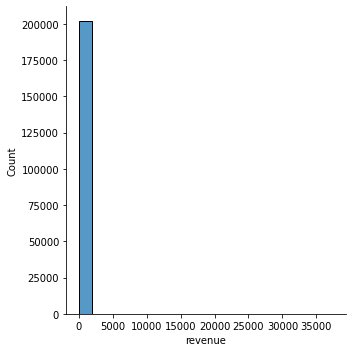

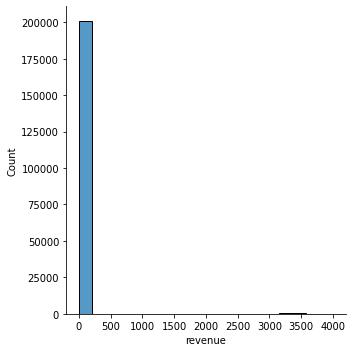

In [51]:
sns.displot(a)
sns.displot(b)

In [52]:
a[a>0].min()

200

In [53]:
a[a>500].min()

37293

In [54]:
a.max()

37433

In [55]:
b[b>0].min()

2000

In [56]:
b.max()

4000

Заметим, насколько сильно различаются диапазоны значений в тестовой и контрольной группах.

Проверим данные на нормальность с помощью теста шапиро-уилка.

Нулевая гипотеза: распределение нормально

In [57]:
pg.normality(a)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
revenue,0.008877,0.0,False


Т.к. p-value <0.05, мы отклоняем нулевую гипотезу.
Следовательно, данные распределены не нормально.

In [58]:
pg.normality(b)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
revenue,0.065882,0.0,False


Т.к. p-value <0.05, мы отклоняем нулевую гипотезу.
Следовательно, данные распределены не нормально.

Распределение ненормально в обеих группах.
Но так как количество данных достаточно велико - требование к нормальности не обязательно (проверка на нормальность была избыточной).
t-тест имеет примущество над тестом Манна-Уитни в сравнении средних, так как даёт более точный результат (к тому же тест Манна-Уитни проверяет другую гипотезу, не о равенстве средних).

Проведём t-тест.

Нулевая гипотеза: метрика ARPU в тестовой и контрольной группе одинакова.

In [59]:
pg.ttest(a,b)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


Так как p-value >0.05, у нас нет оснований отклонить нулевую гипотезу.

Отличие arpu между группами оказалось статистически не значимым.

#### Оценим метрику ARPPU

Показатель ARPU (Average Revenue Per User) — это средняя прибыль компании от одного активного пользователя за конкретный период. Для расчета метрики берут в учет всю аудиторию, а не только покупателей. Показатель ARPPU отличается тем, что отражает средний доход исключительно от каждого платящего клиента.


Сколько платящих пользователей в тестовой и контрольной группах?

In [60]:
df[df.revenue>0].groupby("testgroup").user_id.nunique()

testgroup
a    1928
b    1805
Name: user_id, dtype: int64

Значение ARPPU в тестовой и контрольных группе:

In [61]:
df[df.revenue>0].groupby("testgroup").revenue.mean()

testgroup
a    2663.998444
b    3003.658172
Name: revenue, dtype: float64

In [62]:
df[df.revenue>0].groupby('testgroup').revenue.sum()/df[df.revenue>0].groupby('testgroup').user_id.nunique()

testgroup
a    2663.998444
b    3003.658172
dtype: float64

In [63]:
(df[df.revenue>0].groupby("testgroup").revenue.mean()['b']/df[df.revenue>0].groupby("testgroup").revenue.mean()['a'])*100-100

12.749997227996346

В тестовой группе метрика ARPPU выросла на 12%.

Проверим, насколько статистически значимо это различие

In [64]:
a=df[df.revenue>0].query("testgroup=='a'").revenue
b=df[df.revenue>0].query("testgroup=='b'").revenue

Посмотрим на распределение revenue в двух группах:

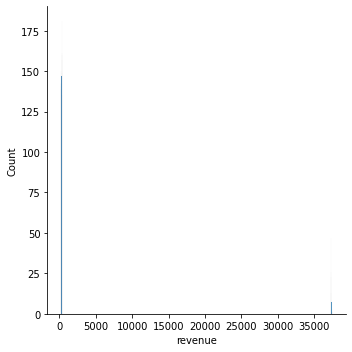

In [65]:
sns.displot(a)

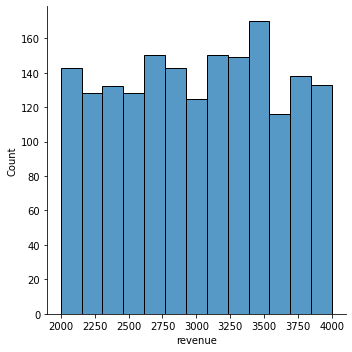

In [66]:
sns.displot(b)

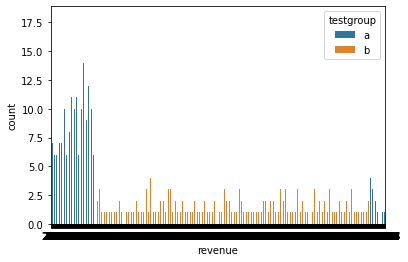

In [67]:
sns.countplot(data=df[df.revenue>0], x="revenue", hue="testgroup")

Заметим, что в контрольной группе есть сильные выбросы и в целом диапазоны значений довольно сильно различаются.

Распределение данных в обоих группах отличается от нормального (опустим проверку с помощью статистического теста).
Но так как количество данных достаточно велико - требование к нормальности не обязательно. 
Используем метод t-test для сравнения средних

Нулевая гипотеза: метрика ARPPU в тестовой и контрольной группах одинакова.

In [70]:
pg.ttest(a,b)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


Так как p-value > 0.05, мы не можем отклонить нулевую гипотезу.
Следовательно, ARPPU в двух группах не отличается.

### Выводы

Мы заметили и статистически подтвердили взаимосвязь между группой и конверсией в платящих пользователей.
Конверсия полльзователей в платящих пользователей в контрольной группе больше на 0.06.

Указанный прирост ARPU на 5% в тестовой не является статистически значимым.

Замеченный нами прирост ARPPU на 12% в тестовой группе мог быть случайным, так как не является статистически значимым.

На основаниие проведенного a/b теста нельзя сделать вывод о преимуществе нового набора предложений над набором предложений в контрольной группе.

Как отмечалось ранее, диапазоны значений прибыли в контрольной и тестовой группах довольно сильно различаются, именно в этом может заключаться признак некорректности проведенного a/b теста.

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?


С помощью следующих метрик можно оценить то, насколько проведенное событие повлияло на вовлеченность пользователя в игру:

1. DAU - количество уникальных пользователей в день
2. Средняя продолжительность сессии (average session length, ASL) – среднее арифметическое длин всех сессий.

3. Количество сеансов (сессий) на пользователя — помогает понять как часто пользователи возвращаются в игру.

С помощью следующих метрик можно оценить то, насколько проведенное события повлияло на удовлетворенность пользователя игрой:

4. NPS (net promoter score) — метрика уровня лояльности пользователей. 
Измеряется с помощью опросников, отражается в процентах. 
NPS измеряет количество постоянных клиентов, которые могут порекомендовать продукт (промоутеры), \
и тех клиентов, которые его ненавидят.

5. Оценка удовлетворенности клиентов (customer satisfaction score, CSAT) — измеряет общий уровень недовольства пользователя по поводу определенного продукта или функции. Пользователей просят оценить продукт или услугу по шкале 1-3, 1-5 или 1- 10. CSAT рассчитывается путем суммирования баллов и деления его на количество респондентов

Также, с помощью фактора виральности, мы можем оценить насколько проведенное событие влияет на привлечение новых пользователей путём инвайта от старых пользователей.

6. Фактор виральности

К−фактор=X⋅Y⋅Z

X — процент пользователей, которые пригласили новых пользователей

Y — среднее число людей, которых пригласил единичный пользователь

Z — число пользователей, принявших приглашение

Чем больше K-фактор, тем стремительнее распространяется ваш продукт по сети и тем он более вирален, то есть нравится аудитории.

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Добавим к перечисленным выше метрикам новую метрику для оценки результата:

Удержание — отношение числа пользователей, дошедших до конца события к числу пользователей, бросивших прохождение события.
